# Demo of two-motor dynamic limit signal

## Overview

Some instrument designs need protection against accidental collision between moving parts during routine operations.  In such cases, each of the axes may be operating between its valid range but an interim (in-motion) state can pose the possibility of a collision.

One such possible collision is when arms of a diffractometer (such as $\theta$ and $2\theta$, known here as `theta` and `ttheta`, respectively) collide causing damage to beam transport apparatus and consequential instrumental downtime.

To prevent the collision *in this case*, the $2\theta$ axis must be at least $\delta$ degrees above the $\theta$ axis.  Empirically, $\delta$ of 3 degrees is sufficient protection.

From a controls safety view, we provide an EPICS PV calculation that is zero when the move is not permitted and one when: ($2\theta - \theta) \ge \delta$.  We'll monitor that PV in Bluesky to add a [suspender](https://blueskyproject.io/bluesky/state-machine.html#automated-suspension) that can interrupt the scan (via the [`bluesky.RunEngine`](https://blueskyproject.io/bluesky/run_engine_api.html?highlight=runengine)) if the permit is removed.  When the RunEngine handles an interruption involving [*movable devices*](https://blueskyproject.io/bluesky/hardware.html?highlight=movables#settable-movable-device), it sends a stop to each of the movables involved.  Thus, when the dynamic limit permit is removed, both motors are stopped and the scan pauses, waiting for external interaction to clear the condition.

<details>
[Here](https://github.com/bluesky/bluesky/blob/4fab894bddbd4a563f28852ea3171b87140ae7b9/bluesky/run_engine.py#L1034-L1036) is where bluesky tells the motors to stop:

```
            if justification is not None:
                print("Justification for this suspension:\n%s" % justification)
            for current_run in self._run_bundlers.values():
                current_run.record_interruption('resume')
            # During suspend, all motors should be stopped. Call stop() on
            # every object we ever set().
            self._stop_movable_objects(success=True)
```

If the RunEngine is started while the dynamic limit permit calculation is zero, the RunEngine will pause immediately.  Here is an example:

```
In [21]: uid = RE(th_tth_scan([noisy, th_tth_permit], 8, 6, points=4, min_sep=3))                               
At least one suspender has tripped. The plan will begin when all suspenders are ready. Justification:
    1. Signal th_tth_permit is low

Suspending... To get to the prompt, hit Ctrl-C twice to pause.
```

We might need to write our own suspender if none of the [provided suspenders](https://blueskyproject.io/bluesky/state-machine.html#built-in-suspenders) will do the job we want.  There is [an example](https://github.com/BCDA-APS/apstools/blob/master/apstools/suspenders.py#L25) of a custom suspender in [apstools](https://apstools.readthedocs.io).

</details>

## Summary

Any time the motors are moved by the bluesky RunEngine, they will be stopped if the dynamic limit permit calculation goes to zero and the scan will pause.


## EPICS setup

We start with two motor axes defined in EPICS.  Here, we run the docker image [`prjemian/synApps`](https://hub.docker.com/r/prjemian/synapps) to make the [EPICS IOC simulator run in a docker container](https://github.com/prjemian/epics-docker/#custom-synappshttps://github.com/prjemian/epics-docker/#custom-synapps) with IOC prefix `gp:`.  These are motor PVs: `gp:m1` and `gp:m2` as shown.

![EPICS motor GUI screens](resources/demo_dynamic_limits_motors.png)

To compute a dynamic limit between the two motor axes, we use a *userCalc* (EPICS [swait](https://htmlpreview.github.io/?https://raw.githubusercontent.com/epics-modules/calc/R3-6-1/documentation/swaitRecord.html) record), `gp:userCalc1` with settings as shown.

1. Set the description field to describe what this does.
1. Monitor each motor's readback (`.RBV`) value.  The readback value is the motor record's *best* knowledge of the actual motor position.
1. `gp:userCalc1.INAN` = `sky:m1.RBV`, the value will be in `A` once the motor moves.
1. `gp:userCalc1.INBN` = `sky:m2.RBV`, the value will be in `B` once the motor moves.
1. Change the calculation's `.SCAN` field from *Passive* (calculates only when requested) to *I/O Intr* (calculate when any input changes, based on each field's *TRIGGER?* setting).
1. Enter the angle of minimum approach (3) into the `gp:userCalc1.C` field.  This will be the PV to change this number.
1. Enter the permit calculation: `(B-A)>=C`

The calculated result (in `gp:userCalc1.VAL`, `gp:userCalc1` for short) once either of the motors move.

![motion permit calculation](resources/demo_dynamic_limits_permit_calc.png)

To scan, we want a "detector".  Let's use another *userCalc* (`gp:userCalc2`) to simulate a noisy detector with a random number generator.  We'll update this detector only when either motor moves (same as with the permit calculation) setting its `.SCAN` to *I/O Intr*.  The setup is shown in the next screen view image:

![noisy detector simulation](resources/demo_dynamic_limits_permit_noisy.png)

## Bluesky setup

In [1]:
# put the instrument package into the path
import pathlib, sys
sys.path.append(str(pathlib.Path.home() / "bluesky"))

# start the instrument package for data collection
from instrument.collection import *
from bluesky import plans as bp
from bluesky import plan_stubs as bps
from ophyd import Component, Device, EpicsMotor, EpicsSignal

bec.disable_plots()  # not interested in graphics in this notebook
RE.waiting_hook = None  # disable the progress bar, looks awful in notebooks

/home/prjemian/bluesky/instrument/_iconfig.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Tue-17:40:18 - ############################################################ startup
I Tue-17:40:18 - logging started
I Tue-17:40:18 - logging level = 10
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/session_logs.py
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/collection.py
I Tue-17:40:18 - CONDA_PREFIX = /home/prjemian/.conda/envs/bluesky_2023_2


Exception reporting mode: Minimal


I Tue-17:40:18 - xmode exception level: 'Minimal'
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/mpl/notebook.py
I Tue-17:40:18 - #### Bluesky Framework ####
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/framework/check_python.py
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/framework/check_bluesky.py
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/framework/initialize.py
I Tue-17:40:18 - RunEngine metadata saved in directory: /home/prjemian/Bluesky_RunEngine_md
I Tue-17:40:18 - using databroker catalog 'training'
I Tue-17:40:18 - using ophyd control layer: pyepics
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/framework/metadata.py
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/epics_signal_config.py
I Tue-17:40:18 - Using RunEngine metadata for scan_id
I Tue-17:40:18 - #### Devices ####
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/devices/area_detector.py
I Tue-17:40:18 - /home/prjemian/bluesky/instrument/devices/calculation_records.py
I Tue-17:40:20 - 

symbol | PV (here) | meaning
--- | --- | ---
`theta` | gp:m1 | (`th`) EPICS motor record
`ttheta` | gp:m2 | (`tth`) EPICS motor record
`th_tth_permit` | gp:userCalc1.VAL | result of EPICS calculation (swait record: 1=permit, 0=not), updates when either motor moves
`th_tth_min` | gp:userCalc1.C | minimum permitted `tth-th`
`noisy` | gp:userCalc2.VAL | detector (random number generator) - integer, updates when either motor moves
`noisy_scale` | gp:userCalc2.C | scale factor for `noisy`

Get the IOC prefix from the instrument configuration (`iconfig`).  If not available, use `"gp:"` as the default.

In [2]:
GP_IOC = iconfig.get("GP_IOC_PREFIX", "gp:")

Define the objects we'll use in this demo.

In [3]:
noisy = EpicsSignal(f"{GP_IOC}userCalc2.VAL", name="noisy")
noisy_scale = EpicsSignal(f"{GP_IOC}userCalc2.C", name="noisy_scale")
th_tth_min = EpicsSignal(f"{GP_IOC}userCalc1.C", name="th_tth_min")
th_tth_permit = EpicsSignal(f"{GP_IOC}userCalc1.VAL", name="th_tth_permit")
noisy.wait_for_connection()
noisy_scale.wait_for_connection()
th_tth_min.wait_for_connection()
th_tth_permit.wait_for_connection()

In [4]:
# We do this ONLY in the simulator.  Real instrument motors may need different settings!
# For this demo, we want to set the theta & ttheta motor backlash to the default condition
# when the IOC is first created.  We'll change this later in the demo.

class BacklashMotor(EpicsMotor):
    backlash_distance = Component(EpicsSignal, ".BDST")
    backlash_velocity = Component(EpicsSignal, ".BVEL")

theta = BacklashMotor(f"{GP_IOC}m1", name="theta", labels=["motors",])
ttheta = BacklashMotor(f"{GP_IOC}m2", name="ttheta", labels=["motors",])
theta.wait_for_connection()
ttheta.wait_for_connection()
%mov ttheta.backlash_distance 0  ttheta.backlash_velocity 2  ttheta.velocity 2
%mov theta.backlash_distance 0  theta.backlash_velocity 1  theta.velocity 2

Setup the two swait records as shown above.

In [5]:
calcs.calc1.reset()
calcs.calc1.description.put("(tth-th) permit")
calcs.calc1.channels.A.input_pv.put(theta.user_readback.pvname)
calcs.calc1.channels.B.input_pv.put(ttheta.user_readback.pvname)
calcs.calc1.channels.C.input_value.put(2.99)
calcs.calc1.calculation.put("(B-A)>=C")
calcs.calc1.precision.put(5)
calcs.calc1.scanning_rate.put("I/O Intr")

calcs.calc2.reset()
calcs.calc2.description.put("noisy")
calcs.calc2.channels.A.input_pv.put(theta.user_readback.pvname)
calcs.calc2.channels.B.input_pv.put(ttheta.user_readback.pvname)
calcs.calc2.channels.C.input_value.put(100_000)
calcs.calc2.calculation.put("floor(RNDM*C+.5)")
calcs.calc2.precision.put(0)
calcs.calc2.scanning_rate.put("I/O Intr")

## Custom Bluesky plan for $\theta:2\theta$ scan

Define a plan for a coupled theta:2theta scan.

In [6]:
def th_tth_scan(detectors, tth_start, tth_end, points=11, min_sep=None):
    """
    run a coupled theta:2theta scan
    """
    min_sep = abs(min_sep or 3)
    old_sep = th_tth_min.get()

    # check end points first!
    if abs(tth_start/2) < min_sep:
        print(
            "Starting point below allowed minimum:"
            f" |{tth_start/2:.4f}| < |{min_sep:.4f}|")
        return
    if abs(tth_end/2) < min_sep:
        print(
            "Ending point below allowed minimum:"
            f" |{tth_end/2:.4f}| < |{min_sep:.4f}|")
        return

    yield from bps.mv(th_tth_min, min_sep)
    yield from bp.scan(
        detectors,
        theta, tth_start/2, tth_end/2,
        ttheta, tth_start, tth_end,
        points
    )

    # reset the previous minimum
    yield from bps.mv(th_tth_min, old_sep)

Try a scan that we know will fail the test for minimum separation.

In [7]:
RE(th_tth_scan([noisy, th_tth_permit], 5, 25, points=11, min_sep=3))

Starting point below allowed minimum: |2.5000| < |3.0000|


()

Swap the two end points, that also fails.

In [8]:
RE(th_tth_scan([noisy, th_tth_permit], 25, 5, points=11, min_sep=3))

Ending point below allowed minimum: |2.5000| < |3.0000|


()

This scan is successful.

In [9]:
RE(th_tth_scan([noisy, th_tth_permit], 9, 7, points=11, min_sep=3))



Transient Scan ID: 899     Time: 2023-04-11 17:40:23
Persistent Unique Scan ID: 'c06b7175-a885-4552-8e5b-b4a5420da7a6'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+------------+---------------+------------+
|   seq_num |       time |      theta |     ttheta | th_tth_permit |      noisy |
+-----------+------------+------------+------------+---------------+------------+
|         1 | 17:40:25.2 |     4.5000 |     9.0000 |       1.00000 |      43064 |
|         2 | 17:40:25.5 |     4.4000 |     8.8000 |       1.00000 |      88511 |
|         3 | 17:40:25.8 |     4.3000 |     8.6000 |       1.00000 |      41773 |
|         4 | 17:40:26.1 |     4.2000 |     8.4000 |       1.00000 |      23136 |
|         5 | 17:40:26.4 |     4.1000 |     8.2000 |       1.00000 |      63299 |
|         6 | 17:40:26.7 |     4.0000 |     8.0000 |       1.00000 |      51217 |
|         7 | 17:40:27.0 |     3.9000 |     7.8000 |       1.00000 |      34130 |
|    

('c06b7175-a885-4552-8e5b-b4a5420da7a6',)

So far, have not registered a permit denied.  Have not encountered a condition where permit _would_ be denied.

## Try to provoke a permit denied

Check the backlash parameters for 2theta motor.  Use the custom motor class that provides the backlash parameters.

In [10]:
# these two motors have backlash support
print(f"{theta.backlash_distance.get()=} ({theta.motor_egu.get()})")
print(f"{theta.backlash_velocity.get()=} ({theta.motor_egu.get()}/s)")

print(f"{ttheta.backlash_distance.get()=} ({ttheta.motor_egu.get()})")
print(f"{ttheta.backlash_velocity.get()=} ({ttheta.motor_egu.get()}/s)")

theta.backlash_distance.get()=0.0 (degrees)
theta.backlash_velocity.get()=1.0 (degrees/s)
ttheta.backlash_distance.get()=0.0 (degrees)
ttheta.backlash_velocity.get()=2.0 (degrees/s)


Change (just) the backlash velocity and set a backlash distance for `ttheta`.

In [11]:
%mov ttheta.backlash_distance 0.5 ttheta.backlash_velocity 0.2
print(f"{ttheta.backlash_distance.get()=} ({ttheta.motor_egu.get()})")
print(f"{ttheta.backlash_velocity.get()=} ({ttheta.motor_egu.get()}/s)")

ttheta.backlash_distance.get()=0.5 (degrees)
ttheta.backlash_velocity.get()=0.2 (degrees/s)


Scan again over a shorter range.

In [12]:
RE(th_tth_scan([noisy, th_tth_permit], 7, 6, points=4, min_sep=3))



Transient Scan ID: 900     Time: 2023-04-11 17:40:28
Persistent Unique Scan ID: '689b3174-515d-44ba-a53a-bcf5dde78e61'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+------------+---------------+------------+
|   seq_num |       time |      theta |     ttheta | th_tth_permit |      noisy |
+-----------+------------+------------+------------+---------------+------------+
|         1 | 17:40:28.6 |     3.5000 |     7.0000 |       1.00000 |      37496 |
|         2 | 17:40:32.2 |     3.3333 |     6.6667 |       1.00000 |      12247 |
|         3 | 17:40:35.8 |     3.1667 |     6.3333 |       1.00000 |      85553 |
|         4 | 17:40:39.4 |     3.0000 |     6.0000 |       0.00000 |       4211 |
+-----------+------------+------------+------------+---------------+------------+
generator scan ['689b3174'] (scan num: 900)


('689b3174-515d-44ba-a53a-bcf5dde78e61',)

**Still**, the permit signal never shows a zero value because it is recorded at the **end** of each step.

Let's monitor the signal _during_ the scan.

In [13]:
sd.monitors.append(th_tth_permit)

Repeat the scan, collecting the new info.  We'll inspect the monitors after the scan is done.  (The RunEngine returns a list of all the run uids created by the plan.  Capture this list.)

In [14]:
uids = RE(th_tth_scan([noisy, th_tth_permit], 8, 6, points=4, min_sep=3))



Transient Scan ID: 901     Time: 2023-04-11 17:40:39
Persistent Unique Scan ID: 'f6e4c671-5962-467b-a5d3-d4da97d0d88d'
New stream: 'label_start_motor'
New stream: 'th_tth_permit_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+---------------+------------+
|   seq_num |       time |      theta |     ttheta | th_tth_permit |      noisy |
+-----------+------------+------------+------------+---------------+------------+
|         1 | 17:40:43.7 |     4.0000 |     8.0000 |       1.00000 |      77908 |
|         2 | 17:40:47.3 |     3.6667 |     7.3333 |       1.00000 |      23212 |
|         3 | 17:40:51.0 |     3.3333 |     6.6667 |       1.00000 |      86056 |
|         4 | 17:40:54.7 |     3.0000 |     6.0000 |       0.00000 |      58289 |
+-----------+------------+------------+------------+---------------+------------+
generator scan ['f6e4c671'] (scan num: 901)


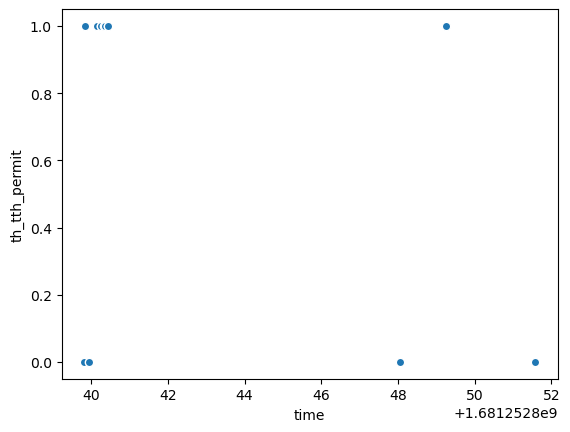

In [15]:
cat[uids[0]].th_tth_permit_monitor.read()["th_tth_permit"].plot.scatter()

Aha!  The first plot shows the monitored values.  It is clear the signal **does** go to 0 and then come back to 1.

Look at the monitored data.  First get the run object from databroker (indexed by the first uid in the list).  From the run object, return the monitored data in a table.  Python prints this object if it is not assigned.  All this in one step.

In [16]:
cat.v1[uids[0]].table("th_tth_permit_monitor")

,time,th_tth_permit
seq_num,,
1,2023-04-11 22:40:39.815230131,0.0
2,2023-04-11 22:40:39.841671467,1.0
3,2023-04-11 22:40:39.943319798,0.0
4,2023-04-11 22:40:40.146294355,1.0
5,2023-04-11 22:40:40.247678757,1.0
6,2023-04-11 22:40:40.252233743,1.0
7,2023-04-11 22:40:40.345250845,1.0
8,2023-04-11 22:40:40.349938154,1.0
9,2023-04-11 22:40:40.447006464,1.0


We see some zero values (and then return to one) indicating occasional removal of the dynamic limit calculation permit.  Since we only saw these when we added a backlash correction, we understand these dynamic violations of the limits are exactly what we hoped to intercept.

## Create a suspender

Block the RunEngine when the permit fails.

N.B. Might need to consider the special case where the permit fails when first starting the run.  Why did that fail? (We'll answer that soon.)

Following this example: https://blueskyproject.io/bluesky/state-machine.html#example-suspend-a-plan-if-the-beam-current-dips-low,
we'll do similar but know that our signal is a boolean, that indicates *no permit* when low.  Suspends interrupt the `RE` as long as the signal is invalid and automatically resume if the signal becomes valid again.  Let's see how this works here.

In [17]:
from bluesky.suspenders import SuspendBoolLow
sus = SuspendBoolLow(th_tth_permit)
RE.install_suspender(sus)

Repeat the scan.

In [18]:
# FIXME
# uids = RE(th_tth_scan([noisy, th_tth_permit], 8, 6, points=4, min_sep=3))

**Failed** before the scan started, when moving the motors to the start position, with th=3.05 and tth=6.05.  We saw this in the previous scans, as well.  This is suspiciously close to the minimum separation and is likely because we moved `theta` *before* moving `ttheta`. 

The signal does not automatically clear since it is only computed when the motor readback value changes.  We can clear this by moving the `ttheta` motor manually.  If we change our plan logic to move `ttheta` first, we might avoid this altogether.  Yet, we could encounter the problem, depending on where the motors are before the scan or the direction of scanning.

Motion is not permitted due to our computation of dynamic limits.  We must move the motors so that the limit permit is restored before we can scan.  We can move the motor from the command line. (This works since this does not use the RunEngine so the suspender is not checked.)

In [19]:
%mov ttheta 6.1

Suspender SuspendBoolLow(EpicsSignal(read_pv='gp:userCalc1.VAL', name='th_tth_permit', value=1.0, timestamp=1681252855.675957, tolerance=1e-05, auto_monitor=True, string=False, write_pv='gp:userCalc1.VAL', limits=False, put_complete=False), sleep=0, pre_plan=None, post_plan=None,tripped_message=) reports a return to nominal conditions. Will sleep for 0 seconds and then release suspension at 2023-04-11 17:40:55.
ttheta:  10%|██▌                       | 0.01/0.1 [00:00<00:01, 20.18s/degrees]
ttheta:  23%|█████▍                  | 0.0226/0.1 [00:00<00:01, 13.29s/degrees]
ttheta:  40%|█████████▋              | 0.0402/0.1 [00:00<00:00,  9.97s/degrees]
ttheta:  60%|██████████████▍         | 0.0602/0.1 [00:00<00:00,  8.33s/degrees]
ttheta:  78%|██████████████████▋     | 0.0777/0.1 [00:00<00:00,  7.73s/degrees]
ttheta:  90%|█████████████████████▋  | 0.0902/0.1 [00:00<00:00,  7.77s/degrees]
ttheta:  98%|███████████████████████▍| 0.0976/0.1 [00:00<00:00,  8.23s/degrees]
ttheta: 100%|████████████

In [20]:
# FIXME
# uids = RE(th_tth_scan([noisy, th_tth_permit], 8, 6, points=4, min_sep=3))

**Failed** during the scan when `theta=3.23` and `ttheta=6.28` and the command line is not responsive.  Move `ttheta` from the GUI in another window.

## Conclusion

We can avoid an anticipated collision of instrument hardware by providing a RunEngine suspender tied to the value of an EPICS PV.